In [8]:
# ========================================================
# Emotional Music Generation - Full AI Pipeline
# Using Autoencoder + Encodec Decoder
# ========================================================

# 1️ Load required libraries and models
import torch
import torchaudio
from encodec import EncodecModel
import numpy as np
import os
import matplotlib.pyplot as plt
# Add project root to sys.path
import sys
import os

project_root = os.path.abspath('..')  
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)

# Now import modules
from utils._modeltraining import EmotionalVAE
from utils._musicgeneration import *

Project root added to sys.path: /Users/meltem/Desktop


In [10]:
# 2️ Define helper function: latent_to_codes_dict
def latent_to_codes_dict(latent_tensor, num_quantizers=8, quantizer_dim=750):
    """
    Converts latent tensor (batch_size, num_quantizers * quantizer_dim)
    into Encodec-compatible codes_dict.

    Returns:
        codes_dict suitable for EncodecModel.decode([(codes_dict, scale)])
    """
    batch_size, total_dim = latent_tensor.shape
    assert total_dim == num_quantizers * quantizer_dim, \
        f"Expected total_dim = {num_quantizers * quantizer_dim}, got {total_dim}"

    # Un-flatten
    latent_tensor = latent_tensor.view(batch_size, num_quantizers, quantizer_dim)

    # For each quantizer, simulate token index by taking argmax across dim
    codes = torch.argmax(latent_tensor, dim=-1)  # (batch_size, num_quantizers)

    # Transpose to match Encodec format: (num_quantizers, num_frames)
    codes = codes.transpose(0, 1)  # (num_quantizers, num_frames)

    codes_dict = {
        'codes': codes
    }

    return codes_dict


In [11]:

# 3 Load trained models

# Load Encodec model - use project-specific factory function
from encodec import EncodecModel

encodec_model = EncodecModel.encodec_model_24khz()
encodec_model.set_target_bandwidth(6.0)  # veya senin kullandığın diğer bandwidth varsa onu yaz
encodec_model = encodec_model.to('cuda' if torch.cuda.is_available() else 'cpu')
encodec_model.eval()

print("Encodec model loaded successfully!")

# Load Autoencoder VAE model
from utils._modeltraining import EmotionalVAE

latent_dim = 750
hidden_dims = [512, 256, 128]
condition_dim = 2

vae_model = EmotionalVAE(latent_dim, hidden_dims, condition_dim)
vae_checkpoint = torch.load('vae_model/vae_final.pt', map_location='cpu')
vae_model.load_state_dict(vae_checkpoint['model_state_dict'])
vae_model = vae_model.to('cuda' if torch.cuda.is_available() else 'cpu')
vae_model.eval()

print("VAE model loaded successfully!")

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Encodec model loaded successfully!
VAE model loaded successfully!


In [12]:
# 4️ Generate samples from Autoencoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model = vae_model.to(device)
encodec_model = encodec_model.to(device)

num_samples = 5
dummy_condition = torch.tensor([0.5, 0.5], dtype=torch.float32).to(device)

with torch.no_grad():
    vae_samples = vae_model.sample(num_samples, dummy_condition, device)  # (num_samples, 6000)

print("VAE samples shape:", vae_samples.shape)


VAE samples shape: torch.Size([5, 8, 750])


In [20]:
def latent_to_full_codes_tensor(latent_tensor, total_num_quantizers=8):
    """
    Converts latent tensor into full codes tensor for Encodec decode.
    Simulates missing quantizer layers with zeros.
    """
    latent_tensor = latent_tensor.squeeze(0)  # (num_frames,)
    layer0_codes = latent_tensor.to(torch.long).unsqueeze(0)  # (1, num_frames)

    num_frames = layer0_codes.shape[1]

    # Simulate other quantizer layers as zeros
    other_layers = torch.zeros(total_num_quantizers - 1, num_frames, dtype=torch.long).to(layer0_codes.device)

    # Concatenate layer 0 with zero layers
    full_codes_tensor = torch.cat([layer0_codes, other_layers], dim=0)  # (num_quantizers, num_frames)

    return full_codes_tensor

Saved: generated_ai_pipeline_music/vae_generated_audio_0.wav


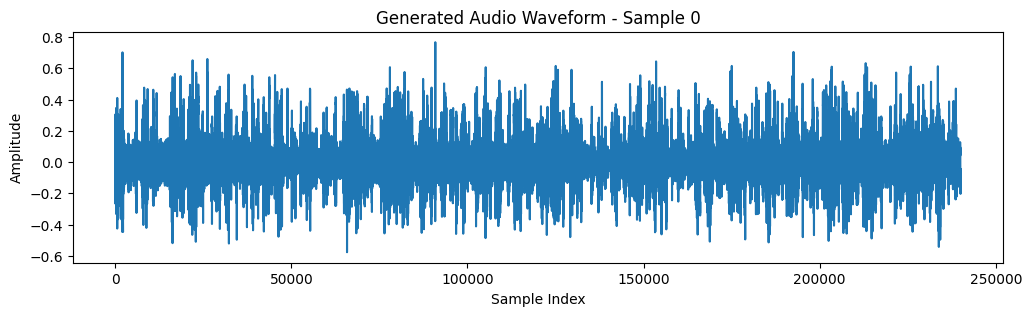

Saved: generated_ai_pipeline_music/vae_generated_audio_1.wav


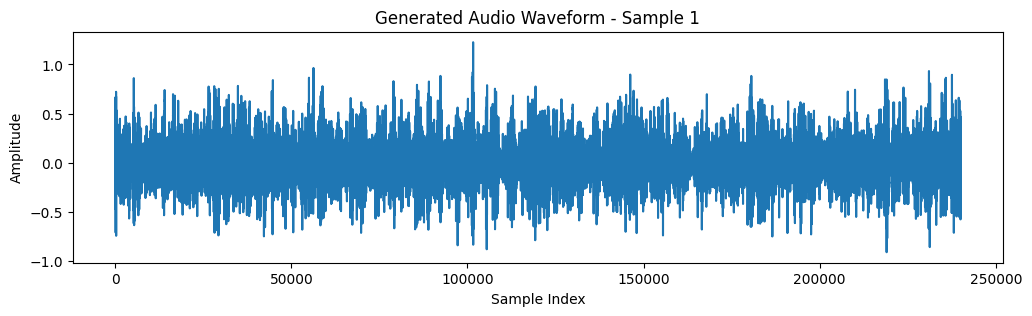

Saved: generated_ai_pipeline_music/vae_generated_audio_2.wav


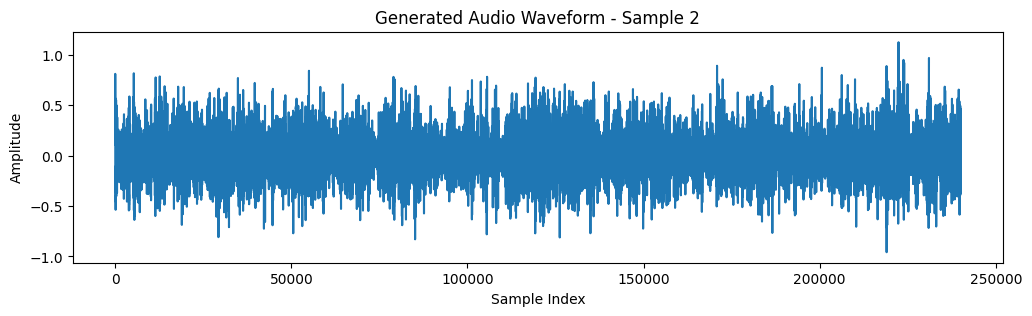

Saved: generated_ai_pipeline_music/vae_generated_audio_3.wav


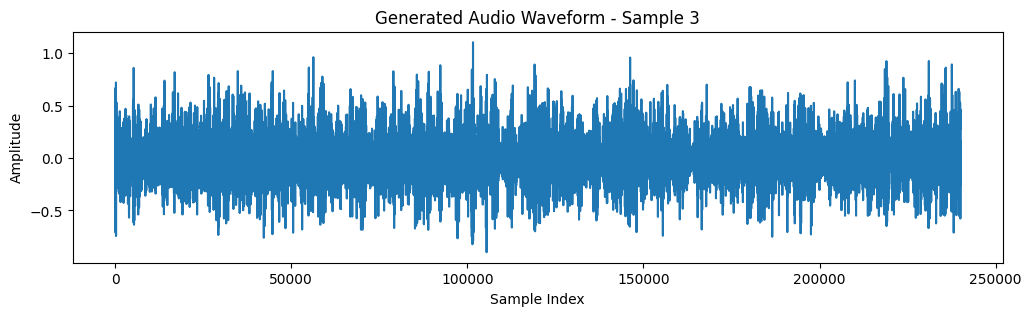

Saved: generated_ai_pipeline_music/vae_generated_audio_4.wav


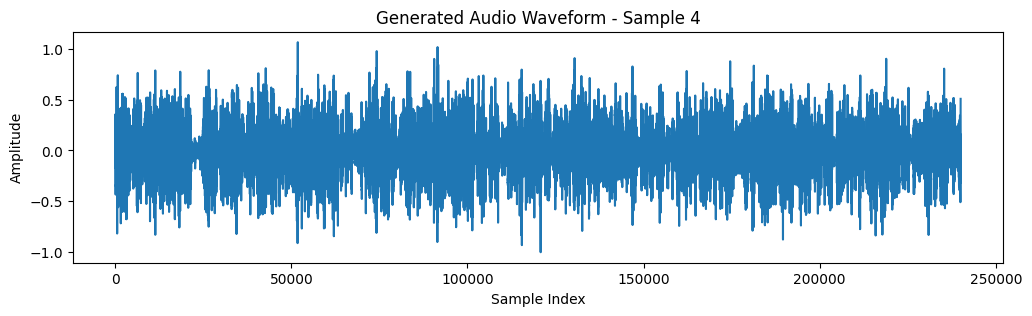

In [21]:
# 5️ Improved loop: generate and save one audio per VAE sample
output_dir = 'generated_ai_pipeline_music'
os.makedirs(output_dir, exist_ok=True)

sample_rate = 24000  # our encodec_model uses 24000 Hz

for i in range(num_samples):
    single_sample = vae_samples[i].unsqueeze(0)  # (1, 6000)

    # Convert latent to codes_tensor
    codes_tensor = latent_to_codes_tensor(single_sample)

    # Decode audio
    scale = torch.ones(1, 1).to(device)
    with torch.no_grad():
        decoded_audio = encodec_model.decode([(codes_tensor, scale)])[0]

    # Save audio
    output_path = os.path.join(output_dir, f'vae_generated_audio_{i}.wav')
    torchaudio.save(output_path, decoded_audio.cpu(), sample_rate)

    print(f"Saved: {output_path}")

    # Optional: plot waveform for each sample
    plt.figure(figsize=(12, 3))
    plt.plot(decoded_audio.cpu().numpy()[0])  # assuming mono channel
    plt.title(f"Generated Audio Waveform - Sample {i}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()